# Dask

!!! Insert Description !!!


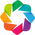

In [1]:
%load_ext memory_profiler
%load_ext snakeviz
%load_ext cython
import holoviews as hv
hv.extension('bokeh','matplotlib')
from IPython.core import debugger
ist = debugger.set_trace

We load in the position and box information created in the *intro* notebook. If you haven't run that notebook, this line will not work! (You don't have to read the wall of text, just run the cells...)

In [24]:
import numpy as np
pos = np.loadtxt('data/positions.dat')
box = np.loadtxt('data/box.dat')

print('Read {:d} positions.'.format(pos.shape[0]))
print('x min/max: {:+4.2f}/{:+4.2f}'.format(pos.min(0)[0],pos.max(0)[0]))
print('y min/max: {:+4.2f}/{:+4.2f}'.format(pos.min(0)[1],pos.max(0)[1]))
print('z min/max: {:+4.2f}/{:+4.2f}'.format(pos.min(0)[2],pos.max(0)[2]))

Read 5000 positions.
x min/max: -25.00/+24.99
y min/max: -24.97/+25.00
z min/max: -24.99/+25.00


## Round 0: Dask Bag Sandbox

In [37]:
import numpy as np
num = 3
lmin = -25 #lower simulation box bound in x, y, and z
lmax = +25 #upper simulation box bound in x, y, and z

L = lmax - lmin
box = np.array([L,L,L])
pos = lmin + np.random.random((num,3))*(lmax-lmin)

print('Positions Array Shape:',pos.shape)
print(pos)

Positions Array Shape: (3, 3)
[[ -3.04184249   3.23419608  11.71273112]
 [ -0.22574634  -2.87192217  22.07351774]
 [-13.84099229  15.1058336    5.4658447 ]]


In [38]:
import numpy as np
import dask.bag as db
import dask

lx = box[0]
ly = box[1]
lz = box[2]
lx2 = box[0]/2.0
ly2 = box[1]/2.0
lz2 = box[2]/2.0
width = 1.0
height = 10.0
box2 = box/2.0

def wrap(x):
    if x[0]>lx2:
        x[0]-=lx
    if x[1]>ly2:
        x[1]-=ly
    if x[2]>lz2:
        x[2]-=lz
    return x

bag = db.from_sequence(np.arange(pos.shape[0]))

future = (bag.product(bag)
             .filter(lambda x: x[0]<x[1])
             .map(lambda x: abs(pos[x[0]] - pos[x[1]]))
             .map(wrap)
             .map(lambda x: np.where(x>box2,x-box,x))
             .map(np.square)
             .map(lambda x: np.sum(x))
             .map(np.sqrt)
             .filter(lambda x: x<width)
             .map(lambda x: np.pi*x/width)
             .map(np.cos)
             .map(lambda x: 0.5*height(1+x))             
              #.map(lambda x: 0.5 * height *(1 + np.cos(np.pi*x/width)))
             .sum()
         )
          
result = future.compute(get=dask.threaded.get)
result

0

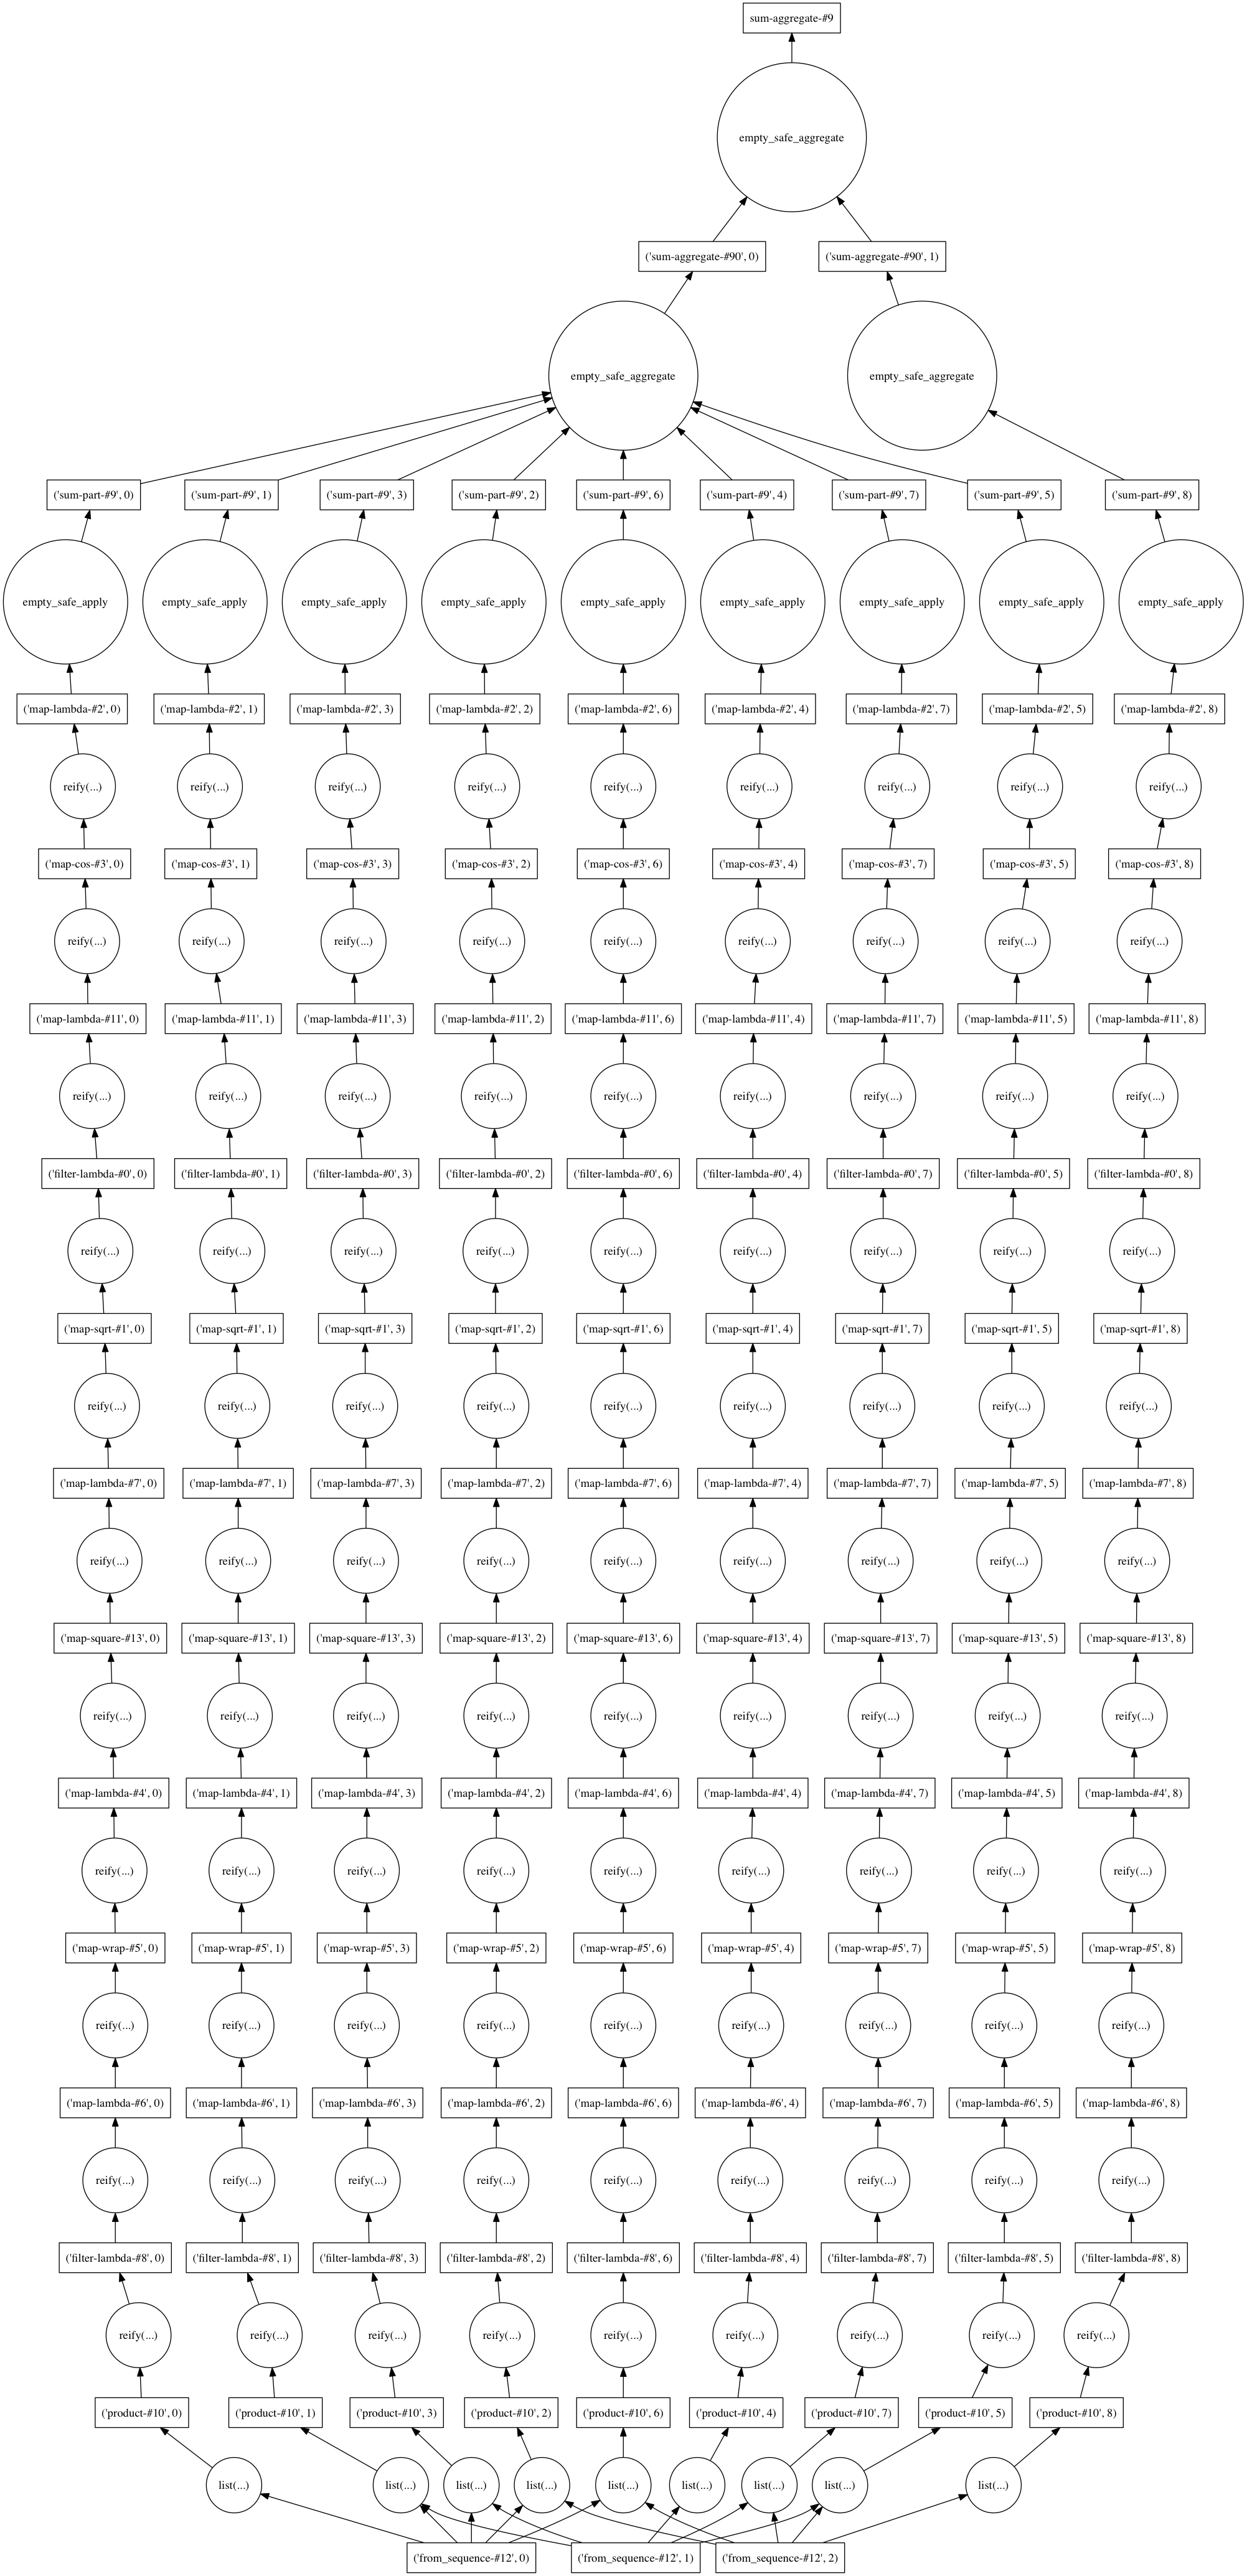

In [39]:
#Warning! only run this with number of positions set to ~3
#future.visualize()